(not SO much improvement, maybe need to tweak LFR hyperparameters a bit)

In [1]:
import sys
import numpy as np
import pandas as pd
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing.lfr import LFR
from aif360.metrics import ClassificationMetric
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import copy
from IPython.display import display
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_adult
from sklearn.linear_model import LogisticRegression
from aif360.datasets import MEPSDataset19
from aif360.datasets import StandardDataset

# Ensure reproducibility
np.random.seed(1)

# Append a path if needed
sys.path.append("../")


pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


Before preprocessing

In [33]:
meps = MEPSDataset19()
df_before, metadata_before = meps.convert_to_dataframe()
df_before

,AGE,RACE,PCS42,MCS42,K6SUM42,REGION=1,REGION=2,REGION=3,REGION=4,SEX=1,...,EMPST=4,POVCAT=1,POVCAT=2,POVCAT=3,POVCAT=4,POVCAT=5,INSCOV=1,INSCOV=2,INSCOV=3,UTILIZATION
0,53.0,1.0,25.93,58.47,3.0,0.0,1.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,56.0,1.0,20.42,26.57,17.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,23.0,1.0,53.12,50.33,7.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,3.0,1.0,-1.00,-1.00,-1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,27.0,0.0,-1.00,-1.00,-1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16573,25.0,0.0,56.71,62.39,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
16574,25.0,0.0,56.71,62.39,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
16575,2.0,1.0,-1.00,-1.00,-1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
16576,54.0,0.0,43.97,42.45,24.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
def further_preprocessing_aif360(meps_dataset):
    """
    Further preprocess the MEPS dataset to prepare it for AIF360 analysis.
    """
    # Convert MEPSDataset19 to a DataFrame
    df, metadata = meps_dataset.convert_to_dataframe()

    # Step 1: Clean invalid values for PCS42 and MCS42
    for col in ['PCS42', 'MCS42']:
        if col in df.columns:
            # Replace negative values with NaN
            df[col] = df[col].apply(lambda x: pd.NA if x < 0 else x)
            # Fill NaN values with the column median
            df[col] = df[col].fillna(df[col].median(skipna=True))


    #Scaling them offers better accuracy but slightly worse fairness metrics
    # Step 2: Scale numerical features
    #scaler = StandardScaler()
    #df[['PCS42', 'MCS42']] = scaler.fit_transform(df[['PCS42', 'MCS42']])


    # Step 3: Group age into decades
    df['Age (decade)'] = df['AGE'].apply(lambda x: min(x // 10 * 10, 70))

    # Step 4: One-hot encode categorical columns
    categorical_columns = ['Age (decade)']
    df = pd.get_dummies(df, columns=categorical_columns)

    # Rename one-hot encoded columns to remove `.0` suffix
    df.rename(columns=lambda col: col.replace('.0', '') if 'Age (decade)' in col else col, inplace=True)

    # Dynamically retrieve column names for encoded categories
    age_decade_columns = [col for col in df.columns if 'Age (decade)_' in col]

    # Step 5: Rename SEX column and convert RACE
    df.rename(columns={'SEX=1': 'SEX'}, inplace=True)
    df['RACE'] = df['RACE'].replace({'White': 1.0, 'Non-White': 0.0})

    # Step 6: Include new features (POVCAT and INSCOV)
    additional_features = [
        'POVCAT=1', 'POVCAT=2', 'POVCAT=3', 'POVCAT=4', 'POVCAT=5',
        'INSCOV=1', 'INSCOV=2', 'INSCOV=3'
    ]

    # Ensure these additional features are present in the dataset
    for feature in additional_features:
        if feature not in df.columns:
            raise ValueError(f"Feature {feature} not found in the dataset.")

    # Step 7: Retain only necessary columns
    selected_columns = (
        ['RACE', 'SEX', 'PCS42', 'MCS42'] +  # Include numerical and protected attributes
        age_decade_columns +
        additional_features +
        ['UTILIZATION']  # Include target variable
    )
    df = df[selected_columns]

    # Step 8: Create the processed AIF360 dataset
    processed_dataset = StandardDataset(
        df,
        label_name='UTILIZATION',
        favorable_classes=[1.0],
        protected_attribute_names=['RACE', 'SEX'],
        privileged_classes=[[1.0], [1.0]],  # Privileged groups: White and Male
    )

    return processed_dataset

# Instantiate MEPSDataset19
meps = MEPSDataset19()

# Apply further preprocessing
processed_meps = further_preprocessing_aif360(meps)

# Inspect the AIF360 dataset
print(processed_meps.feature_names)

['RACE', 'SEX', 'PCS42', 'MCS42', 'Age (decade)_0', 'Age (decade)_10', 'Age (decade)_20', 'Age (decade)_30', 'Age (decade)_40', 'Age (decade)_50', 'Age (decade)_60', 'Age (decade)_70', 'POVCAT=1', 'POVCAT=2', 'POVCAT=3', 'POVCAT=4', 'POVCAT=5', 'INSCOV=1', 'INSCOV=2', 'INSCOV=3']


In [88]:
df, metadata = processed_meps.convert_to_dataframe()
df

,RACE,SEX,PCS42,MCS42,Age (decade)_0,Age (decade)_10,Age (decade)_20,Age (decade)_30,Age (decade)_40,Age (decade)_50,...,Age (decade)_70,POVCAT=1,POVCAT=2,POVCAT=3,POVCAT=4,POVCAT=5,INSCOV=1,INSCOV=2,INSCOV=3,UTILIZATION
0,1.0,1.0,25.930,58.47,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,1.0,0.0,20.420,26.57,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,1.0,0.0,53.120,50.33,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,1.0,53.435,54.37,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,0.0,1.0,53.435,54.37,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16573,0.0,1.0,56.710,62.39,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
16574,0.0,0.0,56.710,62.39,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
16575,1.0,0.0,53.435,54.37,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
16576,0.0,0.0,43.970,42.45,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [89]:
privileged_groups = [{'RACE': 1}]
unprivileged_groups = [{'RACE': 0}]
preprocessed_dataset = processed_meps
train, val_test = preprocessed_dataset.split([0.7], shuffle=True)
val, test = val_test.split([0.5], shuffle=True)

In [90]:
# Print general metadata and attributes about the dataset

print(" - Favorable Label:", preprocessed_dataset.favorable_label)
print(" - Unfavorable Label:", preprocessed_dataset.unfavorable_label)
print(" - Feature Names:", preprocessed_dataset.feature_names)
print(" - Protected Attribute Names:", preprocessed_dataset.protected_attribute_names)
print(" - Privileged Protected Attributes:", preprocessed_dataset.privileged_protected_attributes)
print(" - Unprivileged Protected Attributes:", preprocessed_dataset.unprivileged_protected_attributes)
print(" - Label Names:", preprocessed_dataset.label_names)
print(" - Training Dataset Shape:", preprocessed_dataset.features.shape)

 - Favorable Label: 1.0
 - Unfavorable Label: 0.0
 - Feature Names: ['RACE', 'SEX', 'PCS42', 'MCS42', 'Age (decade)_0', 'Age (decade)_10', 'Age (decade)_20', 'Age (decade)_30', 'Age (decade)_40', 'Age (decade)_50', 'Age (decade)_60', 'Age (decade)_70', 'POVCAT=1', 'POVCAT=2', 'POVCAT=3', 'POVCAT=4', 'POVCAT=5', 'INSCOV=1', 'INSCOV=2', 'INSCOV=3']
 - Protected Attribute Names: ['RACE', 'SEX']
 - Privileged Protected Attributes: [array([1.]), array([1.])]
 - Unprivileged Protected Attributes: [array([0.]), array([0.])]
 - Label Names: ['UTILIZATION']
 - Training Dataset Shape: (15830, 20)


In [91]:
# Check data types and null values
print(df.info())

# Summary statistics for numerical columns
print(df.describe())

# Count of each label
print(df['UTILIZATION'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 15830 entries, 0 to 16577
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RACE             15830 non-null  float64
 1   SEX              15830 non-null  float64
 2   PCS42            15830 non-null  float64
 3   MCS42            15830 non-null  float64
 4   Age (decade)_0   15830 non-null  float64
 5   Age (decade)_10  15830 non-null  float64
 6   Age (decade)_20  15830 non-null  float64
 7   Age (decade)_30  15830 non-null  float64
 8   Age (decade)_40  15830 non-null  float64
 9   Age (decade)_50  15830 non-null  float64
 10  Age (decade)_60  15830 non-null  float64
 11  Age (decade)_70  15830 non-null  float64
 12  POVCAT=1         15830 non-null  float64
 13  POVCAT=2         15830 non-null  float64
 14  POVCAT=3         15830 non-null  float64
 15  POVCAT=4         15830 non-null  float64
 16  POVCAT=5         15830 non-null  float64
 17  INSCOV=1         

In [92]:
# Evaluate fairness metrics before applying bias mitigation
metric_train = BinaryLabelDatasetMetric(train, unprivileged_groups, privileged_groups)
print("Train Dataset (Before Transformation):")
print(f"  Statistical Parity Difference: {metric_train.mean_difference():.4f}")
print(f"  Disparate Impact: {metric_train.disparate_impact():.4f}")

metric_test = BinaryLabelDatasetMetric(test, unprivileged_groups, privileged_groups)
print("\nTest Dataset (Before Transformation):")
print(f"  Statistical Parity Difference: {metric_test.mean_difference():.4f}")
print(f"  Disparate Impact: {metric_test.disparate_impact():.4f}")

Train Dataset (Before Transformation):
  Statistical Parity Difference: -0.1281
  Disparate Impact: 0.4984

Test Dataset (Before Transformation):
  Statistical Parity Difference: -0.1460
  Disparate Impact: 0.4579


In [93]:
# Apply Learning Fair Representations (LFR)
lfr = LFR(unprivileged_groups=unprivileged_groups,
          privileged_groups=privileged_groups,
          k=10, Ax=0.1, Ay=1.0, Az=2.0, 
           verbose=1)
train_transf = lfr.fit_transform(train)
val_transf = lfr.transform(val)
test_transf = lfr.transform(test)

step: 0, loss: 54.62251351614455, L_x: 539.8414901169119,  L_y: 0.6374661848461689,  L_z: 0.0004491598035956397
step: 250, loss: 54.26539156337349, L_x: 537.4006720128109,  L_y: 0.5244353913055247,  L_z: 0.00044448539343865253
step: 500, loss: 51.830140618981474, L_x: 509.6470752941891,  L_y: 0.8646085254849684,  L_z: 0.0004122820387941189
step: 750, loss: 53.168738916893055, L_x: 527.0746072302254,  L_y: 0.4604349196807027,  L_z: 0.0004216370949063096
step: 1000, loss: 51.90517514288372, L_x: 513.1647964112161,  L_y: 0.5878809829838844,  L_z: 0.0004072593891103095
step: 1250, loss: 2.670438562741593, L_x: 9.799856461289778,  L_y: 1.6734486312152461,  L_z: 0.008502142698684578
step: 1500, loss: 14.068716292191013, L_x: 133.99406098425342,  L_y: 0.6691856413750326,  L_z: 6.227619531922985e-05
step: 1750, loss: 1.3969637179821535, L_x: 7.0667620766520045,  L_y: 0.6610566009212289,  L_z: 0.014615454697862119
step: 2000, loss: 9.52290045417186, L_x: 90.58770797440346,  L_y: 0.4625883067066

In [94]:
# Evaluate fairness metrics after applying LFR
metric_train_after = BinaryLabelDatasetMetric(train_transf, unprivileged_groups, privileged_groups)
print("\nTrain Dataset (After Transformation):")
print(f"  Statistical Parity Difference: {metric_train_after.mean_difference():.4f}")
print(f"  Disparate Impact: {metric_train_after.disparate_impact():.4f}")

metric_test_after = BinaryLabelDatasetMetric(test_transf, unprivileged_groups, privileged_groups)
print("\nTest Dataset (After Transformation):")
print(f"  Statistical Parity Difference: {metric_test_after.mean_difference():.4f}")
print(f"  Disparate Impact: {metric_test_after.disparate_impact():.4f}")



Train Dataset (After Transformation):
  Statistical Parity Difference: -0.0294
  Disparate Impact: 0.5973

Test Dataset (After Transformation):
  Statistical Parity Difference: -0.0293
  Disparate Impact: 0.6247


In [95]:
print("Privileged Group Positive Outcomes:", sum(train_transf.labels[train_transf.protected_attributes[:, 0] == 1]))
print("Unprivileged Group Positive Outcomes:", sum(train_transf.labels[train_transf.protected_attributes[:, 0] == 0]))


Privileged Group Positive Outcomes: [291.]
Unprivileged Group Positive Outcomes: [309.]


In [96]:
# Standardize the features
scaler = StandardScaler()
train.features = scaler.fit_transform(train.features)
val.features = scaler.transform(val.features)
test.features = scaler.transform(test.features)


In [97]:
classifier = LogisticRegression(random_state=1)


In [98]:
# Train a classifier on original training data
classifier.fit(train.features, train.labels.ravel())

# Predict on validation set
val_scores = classifier.predict_proba(val.features)[:, 1] #only for the favorable class?

# Select best threshold for validation set
thresholds = np.arange(0.01, 1, 0.01)
val_balanced_accs = []

for threshold in thresholds:
    val_LR_predictions = (val_scores >= threshold).astype(int)

    val_with_LR_scores = copy.deepcopy(val)
    val_with_LR_scores.labels = val_LR_predictions.reshape(-1, 1)  # Update labels with predictions

    val_metric = ClassificationMetric(val, val_with_LR_scores,
                                      unprivileged_groups=unprivileged_groups,
                                      privileged_groups=privileged_groups)
    balanced_acc = (val_metric.true_positive_rate() + val_metric.true_negative_rate()) / 2
    val_balanced_accs.append(balanced_acc)

best_index = np.argmax(val_balanced_accs)
best_threshold = thresholds[best_index]
best_balanced_acc = val_balanced_accs[best_index]

print(f"Best Threshold (validation): {best_threshold}")
print(f"Best Balanced Accuracy (validation): {best_balanced_acc}")

Best Threshold (validation): 0.18000000000000002
Best Balanced Accuracy (validation): 0.7430734484842701


In [99]:
# Apply the best threshold to the test set
test_scores = classifier.predict_proba(test.features)[:, 1]
test_LR_predictions= (test_scores >= best_threshold).astype(int)

# Create a copy of the test dataset and set predicted labels
test_with_LR_scores = copy.deepcopy(test)
test_with_LR_scores.labels = test_LR_predictions.reshape(-1, 1)

# Calculate fairness and performance metrics on the test set
test_metric = ClassificationMetric(test, test_with_LR_scores,
                                   unprivileged_groups=unprivileged_groups,
                                   privileged_groups=privileged_groups)

# Balanced Accuracy
true_positive_rate = test_metric.true_positive_rate()
true_negative_rate = test_metric.true_negative_rate()
balanced_accuracy = (true_positive_rate + true_negative_rate) / 2
print(f"Balanced Accuracy (test): {balanced_accuracy}")

# Statistical Parity Difference
statistical_parity_difference = test_metric.statistical_parity_difference()
print(f"Statistical Parity Difference (test): {statistical_parity_difference}")

# Disparate Impact
disparate_impact = test_metric.disparate_impact()
print(f"Disparate Impact (test): {disparate_impact}")

# Average Odds Difference
average_odds_difference = test_metric.average_odds_difference()
print(f"Average Odds Difference (test): {average_odds_difference}")

# Equal Opportunity Difference
equal_opportunity_difference = test_metric.equal_opportunity_difference()
print(f"Equal Opportunity Difference (test): {equal_opportunity_difference}")

# Theil Index
theil_index = test_metric.theil_index()
print(f"Theil Index (test): {theil_index}")

Balanced Accuracy (test): 0.7586286988433131
Statistical Parity Difference (test): -0.28227485544558717
Disparate Impact (test): 0.4135791138684896
Average Odds Difference (test): -0.19893718252851383
Equal Opportunity Difference (test): -0.1741787624140566
Theil Index (test): 0.09540632792757774


In [100]:
# Plot Test Metrics Over Thresholds
test_balanced_accs = []
test_disp_impacts = []
test_avg_odds_diffs = []

for threshold in thresholds:
    test_predictions = (test_scores >= threshold).astype(int)
    test_with_scores = copy.deepcopy(test)
    test_with_scores.labels = test_predictions.reshape(-1, 1)

    test_metric = ClassificationMetric(test, test_with_scores, unprivileged_groups, privileged_groups)
    test_balanced_accs.append((test_metric.true_positive_rate() + test_metric.true_negative_rate()) / 2)
    test_disp_impacts.append(test_metric.disparate_impact())
    test_avg_odds_diffs.append(test_metric.average_odds_difference())

c:\Users\festa\AppData\Local\Programs\Python\Python312\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


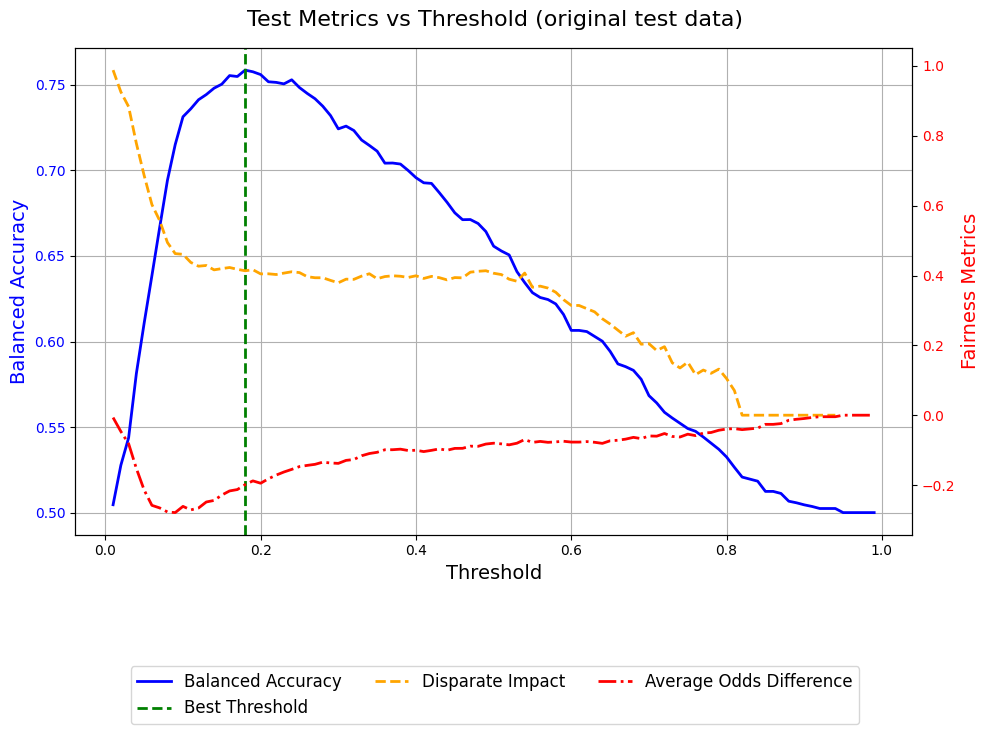

In [101]:
# Create the figure and primary y-axis for Balanced Accuracy
fig, ax1 = plt.subplots(figsize=(10, 6))

# Balanced Accuracy
ax1.plot(thresholds, test_balanced_accs, label="Balanced Accuracy", color="blue", linewidth=2)
ax1.set_xlabel("Threshold", fontsize=14)
ax1.set_ylabel("Balanced Accuracy", color="blue", fontsize=14)
ax1.tick_params(axis='y', labelcolor="blue")
ax1.grid()

# Secondary y-axis for Disparate Impact and Equal Opportunity Difference
ax2 = ax1.twinx()

# Disparate Impact
ax2.plot(thresholds, test_disp_impacts, label="Disparate Impact", color="orange", linestyle="--", linewidth=2)

# Average Odds Difference
ax2.plot(thresholds, test_avg_odds_diffs, label="Average Odds Difference", color="red", linestyle="-.", linewidth=2)

ax2.set_ylabel("Fairness Metrics", color="red", fontsize=14)
ax2.tick_params(axis='y', labelcolor="red")

# Highlight the best threshold
ax1.axvline(best_threshold, color='green', linestyle='--', linewidth=2, label="Best Threshold")

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(lines1 + lines2, labels1 + labels2, loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=12)

# Title and layout adjustments
fig.suptitle("Test Metrics vs Threshold (original test data)", fontsize=16)
fig.tight_layout()
plt.show()

TRANSFORMED DATASET

Unlike reweighing, where a classifier must be trained to evaluate predictions after adjusting instance weights, LFR generates its own scores as part of its optimization process. These scores are computed to balance reconstruction accuracy, prediction accuracy, and fairness. Since LFR directly provides these fairness-aware scores, there is no need to train a separate classifier on the transformed dataset.

In [102]:
# Apply the best threshold to the transf test set
test_transf_scores = test_transf.scores.ravel()
test_transf_LR_predictions= (test_transf_scores >= best_threshold).astype(int)

# Create a copy of the test dataset and set predicted labels
test_transf_with_LR_scores = copy.deepcopy(test)
test_transf_with_LR_scores.labels = test_transf_LR_predictions.reshape(-1, 1)

# Calculate fairness and performance metrics on the test set
test_transf_metric = ClassificationMetric(test, test_transf_with_LR_scores,
                                   unprivileged_groups=unprivileged_groups,
                                   privileged_groups=privileged_groups)

# Balanced Accuracy
true_positive_rate = test_transf_metric.true_positive_rate()
true_negative_rate = test_transf_metric.true_negative_rate()
balanced_accuracy_transf = (true_positive_rate + true_negative_rate) / 2
print(f"Balanced Accuracy (test): {balanced_accuracy_transf}")

# Statistical Parity Difference
statistical_parity_difference_transf = test_transf_metric.statistical_parity_difference()
print(f"Statistical Parity Difference (test): {statistical_parity_difference_transf}")

# Disparate Impact
disparate_impact_transf = test_transf_metric.disparate_impact()
print(f"Disparate Impact (test): {disparate_impact_transf}")

# Average Odds Difference
average_odds_difference_transf = test_transf_metric.average_odds_difference()
print(f"Average Odds Difference (test): {average_odds_difference_transf}")

# Equal Opportunity Difference
equal_opportunity_difference_transf = test_transf_metric.equal_opportunity_difference()
print(f"Equal Opportunity Difference (test): {equal_opportunity_difference_transf}")

# Theil Index
theil_index_transf = test_transf_metric.theil_index()
print(f"Theil Index (test): {theil_index_transf}")

Balanced Accuracy (test): 0.6311260277790681
Statistical Parity Difference (test): -0.028598955428223716
Disparate Impact (test): 0.8141067897165458
Average Odds Difference (test): 0.00709259780467212
Equal Opportunity Difference (test): 0.002291825821237603
Theil Index (test): 0.14771154865174574


In [103]:
# Plot Test Metrics Over Thresholds
test_transf_balanced_accs = []
test_transf_disp_impacts = []
test_transf_avg_odds_diffs = []

for threshold in thresholds:
    test_transf_predictions = (test_transf_scores >= threshold).astype(int)
    test_transf_with_scores = copy.deepcopy(test)
    test_transf_with_scores.labels = test_transf_predictions.reshape(-1, 1)

    test_transf_metric = ClassificationMetric(test, test_transf_with_scores, unprivileged_groups, privileged_groups)
    test_transf_balanced_accs.append((test_transf_metric.true_positive_rate() + test_transf_metric.true_negative_rate()) / 2)
    test_transf_disp_impacts.append(test_transf_metric.disparate_impact())
    test_transf_avg_odds_diffs.append(test_transf_metric.average_odds_difference())

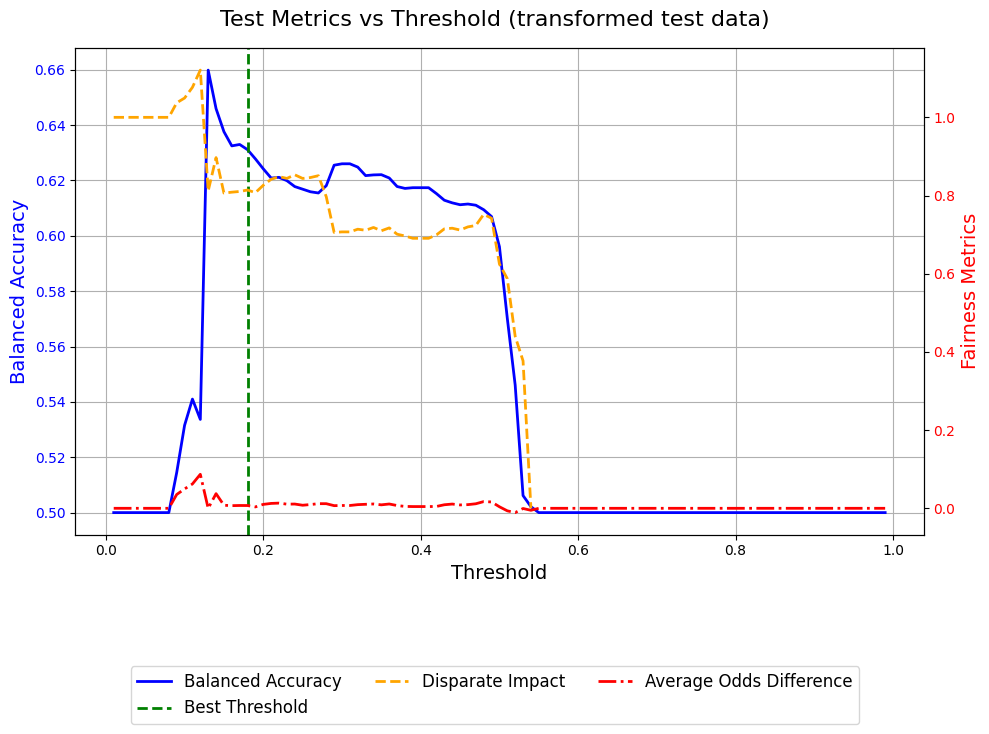

In [104]:
# Create the figure and primary y-axis for Balanced Accuracy
fig, ax1 = plt.subplots(figsize=(10, 6))

# Balanced Accuracy
ax1.plot(thresholds, test_transf_balanced_accs, label="Balanced Accuracy", color="blue", linewidth=2)
ax1.set_xlabel("Threshold", fontsize=14)
ax1.set_ylabel("Balanced Accuracy", color="blue", fontsize=14)
ax1.tick_params(axis='y', labelcolor="blue")
ax1.grid()

# Secondary y-axis for Disparate Impact and Equal Opportunity Difference
ax2 = ax1.twinx()

# Disparate Impact
ax2.plot(thresholds, test_transf_disp_impacts, label="Disparate Impact", color="orange", linestyle="--", linewidth=2)

# Average Odds Difference
ax2.plot(thresholds, test_transf_avg_odds_diffs, label="Average Odds Difference", color="red", linestyle="-.", linewidth=2)

#ax2.set_ylim(-0.05, 0.07)  # I could do this in order to see the average odds better but then i dont see disparate impact, therefore its maybe better to either make abs 1-disparate OR plot two different plots 
ax2.set_ylabel("Fairness Metrics", color="red", fontsize=14)
ax2.tick_params(axis='y', labelcolor="red")

# Highlight the best threshold
ax1.axvline(best_threshold, color='green', linestyle='--', linewidth=2, label="Best Threshold")

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(lines1 + lines2, labels1 + labels2, loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=12)

# Title and layout adjustments
fig.suptitle("Test Metrics vs Threshold (transformed test data)", fontsize=16)
fig.tight_layout()
plt.show()

In [105]:
# Organizing the metrics with actual calculated values
results_data = {
    "Dataset": [
        "Train", "Train", "Test", "Test", 
        "Train", "Train", "Test", "Test", 
        "Validation", "Validation", 
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)"
    ],
    "Stage": [
        "Before Transformation", "After Transformation", 
        "Before Transformation", "After Transformation",
        "Before Transformation", "After Transformation", 
        "Before Transformation", "After Transformation",
        "Best Threshold (Validation)", "Best Threshold (Validation)",
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold"
    ],
    "Metric": [
        "Statistical Parity Difference", "Statistical Parity Difference",
        "Statistical Parity Difference", "Statistical Parity Difference",
        "Disparate Impact", "Disparate Impact",
        "Disparate Impact", "Disparate Impact",
        "Threshold", "Balanced Accuracy",
        "Balanced Accuracy", "Balanced Accuracy", 
        "Statistical Parity Difference", "Statistical Parity Difference", 
        "Disparate Impact", "Disparate Impact",
        "Average Odds Difference", "Average Odds Difference",
        "Equal Opportunity Difference", "Equal Opportunity Difference", 
        "Theil Index", "Theil Index"
    ],
    "Value": [
        metric_train.mean_difference(),
        metric_train_after.mean_difference(),
        metric_test.mean_difference(),
        metric_test_after.mean_difference(),
        metric_train.disparate_impact(),
        metric_train_after.disparate_impact(),
        metric_test.disparate_impact(),
        metric_test_after.disparate_impact(),
        best_threshold,
        best_balanced_acc,
        balanced_accuracy, balanced_accuracy_transf,
        statistical_parity_difference, statistical_parity_difference_transf,
        disparate_impact, disparate_impact_transf,
        average_odds_difference, average_odds_difference_transf,
        equal_opportunity_difference, equal_opportunity_difference_transf,
        theil_index, theil_index_transf
    ]
}

# Create the DataFrame
results_table = pd.DataFrame(results_data)

# Display the table
#display(results_table)


**Fairness Metrics Before and After Transformation**
- This table represents the fairness metrics (Statistical Parity Difference and Disparate Impact) for both the train and test datasets, before and after applying the transformation.

**Validation Metrics for Threshold Selection**
- This table contains metrics related to the validation phase, including the best threshold and corresponding balanced accuracy.

**Test Metrics After Applying Threshold**
- This table summarizes fairness and performance metrics calculated on the test set of the original and transformed dataset after applying the selected threshold.


In [106]:
# Separate the data into three groups
fairness_metrics = results_table.iloc[0:8].reset_index(drop=True)
validation_metrics = results_table.iloc[8:10].reset_index(drop=True)
test_metrics = results_table.iloc[10:22].reset_index(drop=True)

# Name the tables
fairness_metrics.name = "Fairness Metrics Before and After Transformation"
validation_metrics.name = "Validation Metrics for Threshold Selection"
test_metrics.name = "Test Metrics After Applying Threshold On Original and Transformed"

# Display the tables with their names
for table in [fairness_metrics, validation_metrics, test_metrics]:
    display(table.name)
    display(table)


'Fairness Metrics Before and After Transformation'

,Dataset,Stage,Metric,Value
0,Train,Before Transformation,Statistical Parity Difference,-0.128126
1,Train,After Transformation,Statistical Parity Difference,-0.029380
2,Test,Before Transformation,Statistical Parity Difference,-0.145961
3,Test,After Transformation,Statistical Parity Difference,-0.029308
4,Train,Before Transformation,Disparate Impact,0.498435
5,Train,After Transformation,Disparate Impact,0.597256
6,Test,Before Transformation,Disparate Impact,0.457859
7,Test,After Transformation,Disparate Impact,0.624681


'Validation Metrics for Threshold Selection'

,Dataset,Stage,Metric,Value
0,Validation,Best Threshold (Validation),Threshold,0.180000
1,Validation,Best Threshold (Validation),Balanced Accuracy,0.743073


'Test Metrics After Applying Threshold On Original and Transformed'

,Dataset,Stage,Metric,Value
0,Test (Original),After Threshold,Balanced Accuracy,0.758629
1,Test (Transformed),After Threshold,Balanced Accuracy,0.631126
2,Test (Original),After Threshold,Statistical Parity Difference,-0.282275
3,Test (Transformed),After Threshold,Statistical Parity Difference,-0.028599
4,Test (Original),After Threshold,Disparate Impact,0.413579
5,Test (Transformed),After Threshold,Disparate Impact,0.814107
6,Test (Original),After Threshold,Average Odds Difference,-0.198937
7,Test (Transformed),After Threshold,Average Odds Difference,0.007093
8,Test (Original),After Threshold,Equal Opportunity Difference,-0.174179
9,Test (Transformed),After Threshold,Equal Opportunity Difference,0.002292
